# Airplane, Leopard, or Dolphin?

### Using the Visual Bag of Word Technique to determine the subject of a photo
#### By Sean Mills

  In this project I will be using a popular method in Computer Vision called **Bag of Visual Words** to try to correctly classify whether the subject of an image is of an airplane, leopard or dolphin. The orgins behind Visual Bag of Words  lie in the Bag of Words technique in Natural Language Processing (or NLP) where a document is scanned and every word is counted and the counts are placed in a histogram. This histogram of word frequencies can then be used to describe this document and derive context from it.   
  Similarly in Bag of Visual Words we extract visual features from an image and use histograms of common features to try to infer what the content of an image is.    
  In this project I will go over all parts of Bag of Visual Words using python with the [Numpy](https://numpy.org/doc/stable/) library for matrix operations, [Scikit-learn](https://scikit-learn.org/stable/) for KMeans and SVMs, [OpenCV](https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_tutorials.html) for feature extraction and [Matplotlib](https://matplotlib.org/) for data visualization.

## Table of Contents

1. [Importing Data](#Importing-Images)
2. [Feature Extraction](#Feature-Extraction)

## Importing Images

In this section I will be importing all of the packages I need for this project as well as importing all of the images I will be using for classification.   
The images I used in this project come from the [Open Images](https://storage.googleapis.com/openimages/web/index.html) library which contains over 600 classes and 1.7 million images all maintained by Google. I also used the 
[OIDv4 Toolkit](https://github.com/EscVM/OIDv4_ToolKit) to help with downloading the needed images without bounding boxes.  
After importing the images and storing them in NumPy arrays I also plotted one image from each class, using OpenCV to mark features. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
import cv2
import os

# Reads all images in given directory
def read_images(image_dir, N=None, resize_val=None):
    img_names = os.listdir(image_dir)
    M = len(img_names)
    imgs = list()
    if (N is not None):
        img_names = img_names[:N]
    
    for i, img_name in enumerate(img_names):
        img_file = os.path.join(image_dir, img_name)
        img = cv2.imread(img_file)
        if img is not None:
            img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            if (resize_val is not None):
                img_gray = cv2.resize(img_gray, (0, 0), fx=0.5, fy=0.5)
            imgs.append(img_gray)
        
    return imgs

airplanes = read_images('..\\OIDv4_ToolKit\\OID\\Dataset\\train\\Airplane')
dolphins = read_images('..\\OIDv4_ToolKit\\OID\\Dataset\\train\\Dolphin')
leopards = read_images('..\\OIDv4_ToolKit\\OID\\Dataset\\train\\Leopard')

In [3]:
def plot_img_and_keypoints(img):
    fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(14, 10))
    ax1.imshow(img, cmap='gray')
    sift = cv2.SIFT_create()
    kp, des = sift.detectAndCompute(img, None)
    img_kp = cv2.drawKeypoints(img, kp, img, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    ax2.imshow(img_kp)

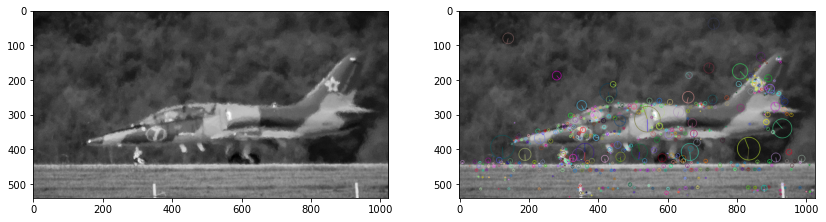

In [4]:
plot_img_and_keypoints(airplanes[4])

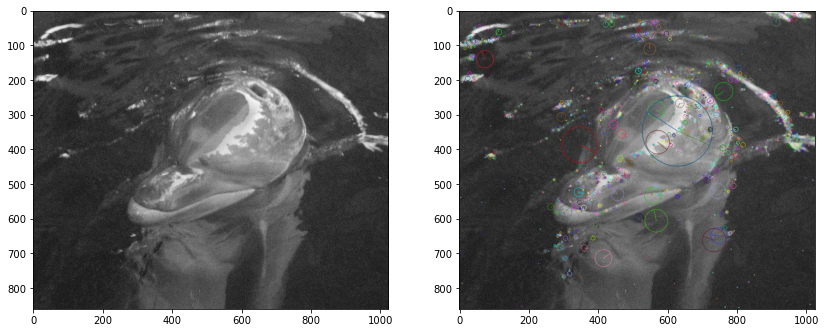

In [5]:
plot_img_and_keypoints(dolphins[0])

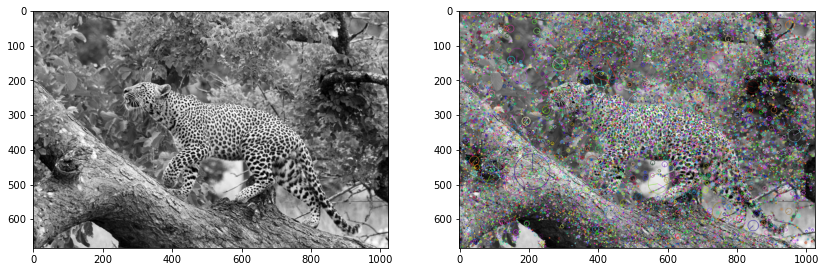

In [6]:
plot_img_and_keypoints(leopards[1])

## Feature Extraction

In [7]:
sift = cv2.SIFT_create()

def get_set_descriptors(image_set, sift, min_kps=70):
    image_set_filtered = []
    keypoints = []
    descips = []
    for img in image_set:
        kp, des = sift.detectAndCompute(img,None)
        if (len(kp) > min_kps):
            image_set_filtered.append(img)
            descips.append(des)
            keypoints.append(kp)
    
    return image_set_filtered, keypoints, descips
        
airplanes_imgs, airplanes_kp, airplanes_des = get_set_descriptors(airplanes, sift)
dolphins_imgs, dolphins_kp, dolphins_des = get_set_descriptors(dolphins, sift)
leopards_imgs, leopards_kp, leopards_des = get_set_descriptors(leopards, sift)

In [8]:
print(len(airplanes_imgs), len(dolphins_imgs), len(leopards_imgs))
print(min(map(len, airplanes_kp)), min(map(len, dolphins_kp)), min(map(len, leopards_kp)))

1772 866 694
73 77 124


In [9]:
def argsort(seq):
    # http://stackoverflow.com/questions/3071415/efficient-method-to-calculate-the-rank-vector-of-a-list-in-python
    return sorted(range(len(seq)), key=seq.__getitem__)[::-1]

def get_top_kp_desc(keypoints, descriptors, n):
    top_kp = []
    top_desc = []
    for keypoint, descriptor in zip(keypoints, descriptors):
        kp_sorted_idx = argsort([kp.response for kp in keypoint])
        top_kp_idx = kp_sorted_idx[:n]
        top_kp.append([keypoint[i] for i in top_kp_idx])
        top_desc.append(descriptor[top_kp_idx,:])
    return top_kp, top_desc

min_kp = 73
kpa, desca = get_top_kp_desc(airplanes_kp, airplanes_des, min_kp)
kpd, descd = get_top_kp_desc(dolphins_kp, dolphins_des, min_kp)
kpl, descl = get_top_kp_desc(leopards_kp, leopards_des, min_kp)

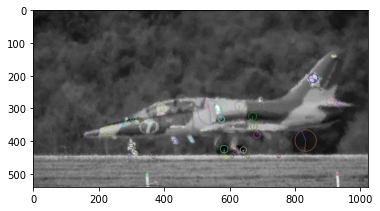

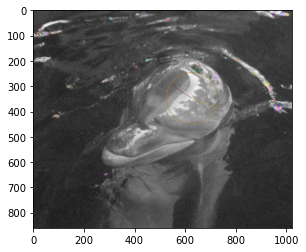

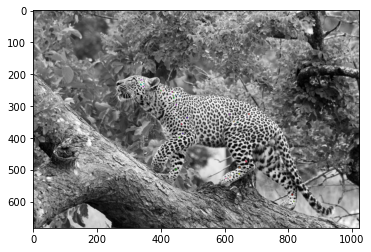

In [10]:
imga=cv2.drawKeypoints(airplanes[4],kpa[4],airplanes[4],flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
imgd=cv2.drawKeypoints(dolphins[0], kpd[0],dolphins[0],flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
imgl=cv2.drawKeypoints(leopards[1], kpl[1],leopards[1],flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(imga)
plt.show()
plt.imshow(imgd)
plt.show()
plt.imshow(imgl)

In [11]:
train_size = 600
desca_train, desca_test, kpa_train, kpa_test, imga_train, imga_test = train_test_split(desca, kpa, airplanes_imgs, train_size=train_size)
descd_train, descd_test, kpd_train, kpd_test, imgd_train, imgd_test = train_test_split(descd, kpd, dolphins_imgs, train_size=train_size)
descl_train, descl_test, kpl_train, kpl_test, imgl_train, imgl_test  = train_test_split(descl, kpl, leopards_imgs, train_size=train_size)
print(len(desca_train), len(desca_test))
print(len(descd_train), len(descd_test))
print(len(descl_train), len(descl_test))

600 1172
600 266
600 94


C:\Users\mills\anaconda3\envs\cmsc426\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [12]:
desca_train_flat = np.vstack(desca_train)
descd_train_flat = np.vstack(descd_train)
descl_train_flat = np.vstack(descl_train)
desca_test_flat = np.vstack(desca_test)
descd_test_flat = np.vstack(descd_test)
descl_test_flat = np.vstack(descl_test)

In [13]:
train_set = np.concatenate((desca_train_flat, descd_train_flat, descl_train_flat))
train_keypoints = [kpa_train, kpd_train, kpl_train]
train_images = [imga_train, imgd_train, imgl_train]
test_set = np.concatenate((desca_test_flat, descd_test_flat, descl_test_flat))
test_keypoints = [kpa_test, kpd_test, kpl_test]
test_images = [imga_test, imgd_test, imgl_test]
# Print shape for check
print(train_set.shape)
print(test_set.shape)

(131400, 128)
(111836, 128)


In [14]:
k = 400
kmeans = KMeans(n_clusters=k)
train_labels = kmeans.fit_predict(train_set)

C:\Users\mills\anaconda3\envs\cmsc426\lib\site-packages\sklearn\metrics\pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


In [26]:
img_class_label = {'airplane': 0, 'dolphin': 1, 'leopard': 2}

def get_histograms_classes(labels, n, k, num_image_per_class, num_kp):
    histograms = np.zeros((n, k))
    class_labels = np.zeros(n, dtype=np.float64)
    labels_reshape = np.reshape(labels, (n, num_kp))
    j = 0

    for img_labels in labels_reshape:
        img_hist = np.bincount(img_labels, minlength=k)
        histograms[j,:] = img_hist
        j += 1

    if type(num_image_per_class) is tuple:
        airplane_size, dolphin_size, leopard_size = num_image_per_class
        class_labels[:airplane_size] = [img_class_label['airplane']] * airplane_size
        class_labels[airplane_size:(airplane_size + dolphin_size)] = [img_class_label['dolphin']] * dolphin_size
        class_labels[(airplane_size + dolphin_size):] = [img_class_label['leopard']] * leopard_size
    else:
        class_labels[:num_image_per_class] = [img_class_label['airplane']] * num_image_per_class
        class_labels[num_image_per_class:(2 * num_image_per_class)] = [img_class_label['dolphin']] * num_image_per_class
        class_labels[(2 * num_image_per_class):] = [img_class_label['leopard']] * num_image_per_class

    return histograms, class_labels


train_histograms, train_classes = get_histograms_classes(train_labels, 3 * train_size, k, train_size, min_kp)
    

In [16]:


# Given the cluster labels, name of image class, image number in class, number of images in class and number of keypoints in image
# Returns the cluster labels for all the keypoints in the image
def get_img_cluster_labels(labels, img_class, img_num, img_per_class, kp_per_img):
    img_class_num = img_class_label.get(img_class)
    if img_class_num is None or img_num > img_per_class:
        raise ValueError('Bad arguments')
    start_idx = img_class_num * img_per_class + img_num * kp_per_img
    end_idx = start_idx + kp_per_img
    return labels[start_idx:end_idx]

# Given the overall keypoint index, number of images per class and number of keypoints per image
# Returns the class number, image number within class, and keypoint number within the image
def get_class_imgnum_from_index(keypoint_index, img_per_class, kp_per_img):
    image_index = keypoint_index // kp_per_img
    class_num = image_index // img_per_class
    image_num = image_index - class_num * img_per_class
    kp_num = keypoint_index % kp_per_img
    if class_num > 2 or image_num < 0 or image_num > img_per_class:
        raise ValueError('Bad arguments; Class num or image num outside range')
    return class_num, image_num, kp_num


In [17]:
def get_img_histogram(histograms, img_class, img_num, img_per_class):
    img_class_num = img_class_label.get(img_class)
    if img_class_num is None or img_num > img_per_class:
        raise ValueError('Bad arguments')
    img_idx = img_class_num * img_per_class + img_num
    return histograms[img_idx]

<BarContainer object of 400 artists>

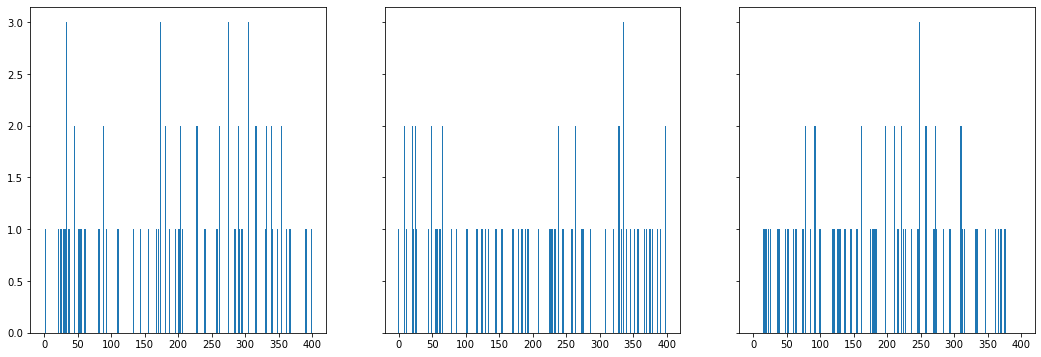

In [18]:
img1_hist = get_img_histogram(train_histograms, 'airplane', 4, train_size)
img2_hist = get_img_histogram(train_histograms, 'dolphin', 0, train_size)
img3_hist = get_img_histogram(train_histograms, 'leopard', 1, train_size)



fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
ax1.bar(range(k), img1_hist, width=2)
ax2.bar(range(k), img2_hist, width=2)
ax3.bar(range(k), img3_hist, width=2)

In [20]:
# Given the overall keypoint index, number of images per class and number of keypoints per image
# Returns the class number, image number within class, and keypoint number within the image
def get_class_imgnum_from_index(keypoint_index, img_per_class, kp_per_img):
    image_index = keypoint_index // kp_per_img
    class_num = image_index // img_per_class
    image_num = image_index - class_num * img_per_class
    kp_num = keypoint_index % kp_per_img
    if class_num > 2 or image_num < 0 or image_num > img_per_class:
        raise ValueError('Bad arguments; Class num or image num outside range')
    return class_num, image_num, kp_num

# Returns the image to the closest of each cluster centroid
def get_cluster_images(labels, centroids, descriptors, keypoints, images, patch_area=30):
    indices = np.arange(descriptors.shape[0])
    cluster_imgs = []
    for center_num, centroid in enumerate(centroids):
        # Get all descriptors within cluster
        kp_indices = np.nonzero(labels == center_num)
        cluster_descs = descriptors[kp_indices]

        # Find descriptor closest to the centroid point
        dists = np.linalg.norm(cluster_descs - centroid, axis=1)
        min_idx = np.argmin(dists)
        descriptor_index = indices[kp_indices][min_idx]

        # Find the class, image, and keypoints that this descriptor came from
        i_class, i_image, i_kp = get_class_imgnum_from_index(descriptor_index, train_size, min_kp)
        image = images[i_class][i_image]
        keypoint = keypoints[i_class][i_image][i_kp]
        
        # Take a small snippet from the keypoint images around the keypoint location
        x, y = keypoint.pt
        image_padded = np.pad(image, patch_area, mode='constant')
        x, y = x + patch_area, y + patch_area
        patch = image_padded[round(y-patch_area):round(y+patch_area),round(x-patch_area):round(x+patch_area)]
        cluster_imgs.append(patch)

    return np.asarray(cluster_imgs)

cluster_images = get_cluster_images(train_labels, kmeans.cluster_centers_, train_set, train_keypoints, train_images)


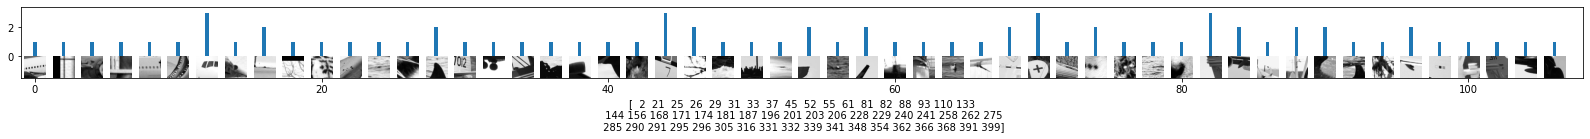

In [22]:
def plot_vocabulary(images, histogram):
    # Get all visual words present in the image
    cluster_nums = np.nonzero(histogram)[0]
    counts = histogram[cluster_nums]
    plt.figure(figsize=(28, 18))
    plt.bar(range(0, 2 * len(cluster_nums), 2), counts, width=0.25)
    for i, cluster_num in enumerate(cluster_nums):
        plt.imshow(images[cluster_num], cmap='gray', extent = (-.75 + 2*i, .75 + 2*i, -1.5, .0))
    plt.xlim(-1, 2 * len(cluster_nums))
    plt.ylim(-1.5, max(counts) * 1.15)
    plt.xlabel(cluster_nums)
    plt.show()
    
plot_vocabulary(cluster_images, img1_hist)

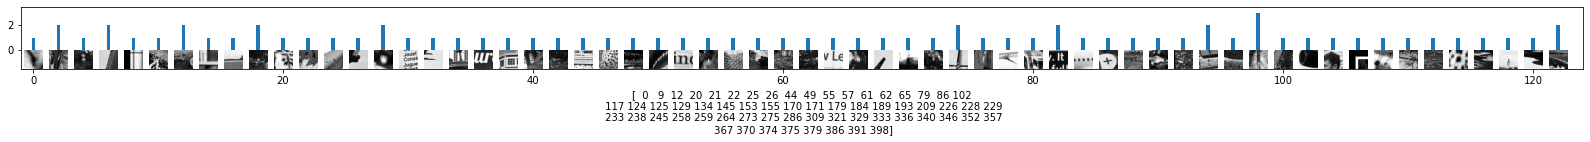

In [23]:
plot_vocabulary(cluster_images, img2_hist)

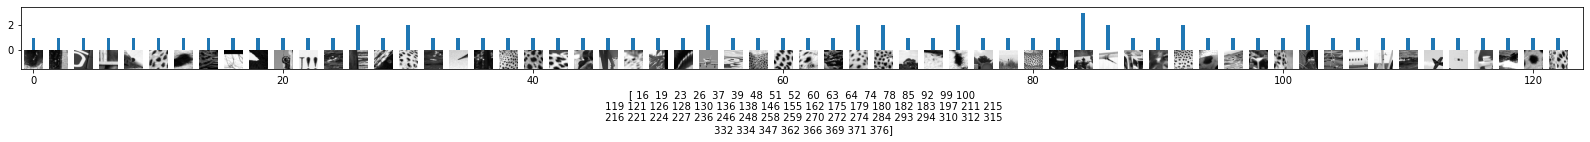

In [24]:
plot_vocabulary(cluster_images,img3_hist)

In [38]:
def plot_vocabulary_keypoints(cluster_images, labels, images, keypoints, class_name, img_num, patch_area=30):
    class_num = img_class_label[class_name]
    img = images[class_num][img_num]
    img_keypoints = keypoints[class_num][img_num]
    img_labels = get_img_cluster_labels(labels, class_name, img_num, train_size, min_kp)
    img_padded = np.pad(img, patch_area, mode='constant')
    for i, (label, keypoint) in enumerate(zip(img_labels, img_keypoints)):
        cluster_img = cluster_images[label]
        x, y = keypoint.pt
        x, y = x + patch_area, y + patch_area
        patch = img_padded[round(y-patch_area):round(y+patch_area),round(x-patch_area):round(x+patch_area)]
        fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(4, 4))
        ax1.imshow(cluster_img, cmap='gray')
        ax2.imshow(patch, cmap='gray')
    plt.show()

# plot_vocabulary_keypoints(cluster_images, train_labels, train_images, train_keypoints, 'airplane', 4)

### Term Frequentcy - Inverse Document Frequency weighting

In [64]:
def get_tf_idf_weights(histograms):
    num_docs = histograms.shape[0]
    idf = np.log(num_docs / np.count_nonzero(train_histograms, axis=0))
    weighted = histograms * idf
    return weighted

train_histograms_weighted = get_tf_idf_weights(train_histograms)

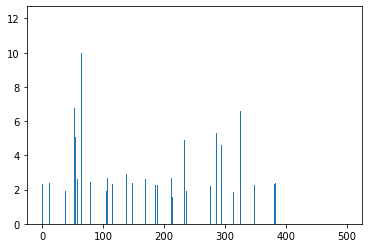

In [65]:
img1_hist = get_img_histogram(train_histograms_weighted, 'airplane', 4, train_size)
plt.bar(range(k), img1_hist)
plt.show()

### SVM & Prediction

In [66]:
shuffle_idx = np.arange(len(train_histograms_weighted))
np.random.shuffle(shuffle_idx)
train_histograms_weighted = train_histograms_weighted[shuffle_idx]
train_classes = train_classes[shuffle_idx]

In [27]:
train_classes

array([0., 0., 0., ..., 2., 2., 2.])

In [39]:
classifier = svm.SVC(kernel='linear', decision_function_shape='ovo')
classifier.fit(train_histograms, train_classes)
print(classifier)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovo', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [40]:
train_predicts = classifier.predict(train_histograms)
train_cm = confusion_matrix(train_classes, train_predicts)
print("confusion matrix")
print("airplane, dolphin, leopard")
print(train_cm)
print("Accuracy: ", (train_cm[0,0] + train_cm[1,1] + train_cm[2,2]) / np.sum(train_cm))

confusion matrix
airplane, dolphin, leopard
[[564  36   0]
 [ 43 557   0]
 [  0   0 600]]
Accuracy:  0.9561111111111111


In [30]:
test_img_sizes = (len(desca_test), len(descd_test), len(descl_test))
test_labels = kmeans.predict(test_set)

In [42]:
test_histograms, test_classes = get_histograms_classes(test_labels, sum(test_img_sizes), k, test_img_sizes, min_kp)
# test_histograms_weighted = get_tf_idf_weights(test_histograms)
predictions = classifier.predict(test_histograms)

In [33]:
print(predictions.shape)
print(test_classes.shape)
print([len(desca_test), len(descd_test), len(descl_test)])

(1532,)
(1532,)
[1172, 266, 94]


In [43]:
test_cm = confusion_matrix(test_classes, predictions)

print("confusion matrix")
print("airplane, dolphin, leopard")
print(test_cm)
print("accuracy: ", (test_cm[0,0] + test_cm[1,1] + test_cm[2,2]) / np.sum(test_cm))

confusion matrix
airplane, dolphin, leopard
[[795 297  80]
 [ 73 161  32]
 [  5  11  78]]
accuracy:  0.674934725848564
